# install and import libraries

In [ ]:
!git clone https://github.com/farhadnawaz/GMR_GP_Imitation_Learning.git

Cloning into 'GMR_GP_Imitation_Learning'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 71 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (71/71), 1.45 MiB | 18.97 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
cd GMR_GP_Imitation_Learning/

/content/GMR_GP_Imitation_Learning


In [ ]:
!git pull

Already up to date.


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3410104 sha256=f3ffb4a9f0fca555188e61eaccb61d582f7f89b83df35d3921f5094100b507c4
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512708 sha256=3a08e49f3b8d07f5c72f71ccf2315e5a139326e4ccfbb4fb38a5ac07e8758bd0
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102544 sha256=a9746ce0f2d

# load SShape (IROS dataset) and train

In [ ]:
#! /usr/bin/env python
##################################################
# Author: Noemie Jaquier, 2019
# License: MIT
# Contact: noemie.jaquier@idiap.ch
##################################################

import numpy as np
import GPy
import matplotlib.pyplot as plt
from scipy.io import loadmat # loading data from matlab
from utils.gmr import Gmr
from utils.gmr import plot_gmm
from utils.gp_coregionalize_with_mean_regression import GPCoregionalizedWithMeanRegression
from utils.gmr_mean_mapping import GmrMeanMapping
from utils.gmr_kernels import Gmr_based_kernel
import argparse
import time
from fastdtw import fastdtw
import warnings
warnings.filterwarnings("ignore")

# GMR-based GPR on 2D trajectories with time as input
# parser = argparse.ArgumentParser()
# parser.add_argument('--letter', default='I', type=str)
# parser.add_argument('--n_gaussian', default=10, type=int)
# parser.add_argument('--n_test_execution', default=5, type=int)
# args = parser.parse_args()

# letter = args.letter
# if letter == 'B':
# 	show_B = args.show_B
# else:
# 	show_B = False

n_gaussian = 20
n_test_execution = 10
letter = 'S'
show_B = False

# if show_B:
# 	letter = 'B'  # choose a letter in the alphabet
# 	datapath = './data/2Dletters/'
# 	data = loadmat(datapath + '%s.mat' % letter)
# 	demos = [d['pos'][0][0].T for d in data['demos'][0]]
# else
# 	demos = np.load('IROS_dataset/'+letter+'Shape.npy')

# Parameters
demos = np.load('IROS_dataset/'+letter+'Shape.npy')
nb_data = demos[0].shape[0]
nb_data_sup = 0
nb_samples = 1
dt = 0.01
input_dim = 1
output_dim = 2
in_idx = [0]
out_idx = [1, 2]
nb_states = n_gaussian

nb_prior_samples = n_test_execution
nb_posterior_samples = 1

# Create time data
demos_t = [np.arange(demos[i].shape[0])[:, None] + 1 for i in range(nb_samples)]
# Stack time and position data
demos_tx = [np.hstack([demos_t[i]*dt, demos[i]]) for i in range(nb_samples)]

# Stack demos
demos_np = demos_tx[0]
for i in range(1, nb_samples):
  demos_np = np.vstack([demos_np, demos_tx[i]])

X = demos_np[:, 0][:, None]
Y = demos_np[:, 1:]

# Train data for GPR
X_list = [np.hstack((X, X)) for i in range(output_dim)]
Y_list = [Y[:, i][:, None] for i in range(output_dim)]

# Test data
Xt = dt * np.arange(demos[0].shape[0] + nb_data_sup)[:, None]
nb_data_test = Xt.shape[0]
Xtest, _, output_index = GPy.util.multioutput.build_XY([np.hstack((Xt, Xt)) for i in range(output_dim)])

# Define via-points (new set of observations)
X_obs = np.array([0.0, 1., 1.9])[:, None]
Y_obs = np.array([[-12.5, -11.5], [-0.5, -1.5], [-14.0, -7.5]])
X_obs_list = [np.hstack((X_obs, X_obs)) for i in range(output_dim)]
Y_obs_list = [Y_obs[:, i][:, None] for i in range(output_dim)]


begin_train = time.time()
# GMM
gmr_model = Gmr(nb_states=nb_states, nb_dim=input_dim + output_dim, in_idx=in_idx, out_idx=out_idx)
gmr_model.init_params_kbins(demos_np.T, nb_samples=nb_samples)
gmr_model.gmm_em(demos_np.T)

# GMR prediction
mu_gmr = []
sigma_gmr = []
for i in range(Xt.shape[0]):
  mu_gmr_tmp, sigma_gmr_tmp, H_tmp = gmr_model.gmr_predict(Xt[i])
  mu_gmr.append(mu_gmr_tmp)
  sigma_gmr.append(sigma_gmr_tmp)

mu_gmr = np.array(mu_gmr)
sigma_gmr = np.array(sigma_gmr)

# Define GPR likelihood and kernels
likelihoods_list = [GPy.likelihoods.Gaussian(name="Gaussian_noise_%s" %j, variance=0.01) for j in range(output_dim)]
# kernel_list = [GPy.kern.RBF(1, variance=1., lengthscale=0.1) for i in range(gmr_model.nb_states)]
kernel_list = [GPy.kern.Matern52(1, variance=1., lengthscale=5.) for i in range(gmr_model.nb_states)]

# Fix variance of kernels
for kernel in kernel_list:
  kernel.variance.fix(1.)
  kernel.lengthscale.constrain_bounded(0.01, 10.)

# Bound noise parameters
for likelihood in likelihoods_list:
  likelihood.variance.constrain_bounded(0.001, 0.05)

# GPR model
K = Gmr_based_kernel(gmr_model=gmr_model, kernel_list=kernel_list)
mf = GmrMeanMapping(2*input_dim+1, 1, gmr_model)

m = GPCoregionalizedWithMeanRegression(X_list, Y_list, kernel=K, likelihoods_list=likelihoods_list, mean_function=mf)

# Parameters optimization
m.optimize('bfgs', max_iters=100, messages=False)

# Print model parameters
#print(m)
print(" ")
print("******* Letter "+letter +" *******")
print(" ")
print("#######################################")
print("Training time",time.time() - begin_train)
print("#######################################")
# GPR prior (no observations)

begin_prior = time.time()
prior_traj = []
prior_mean = mf.f(Xtest)[:, 0]
prior_kernel = m.kern.K(Xtest)
prior_time = time.time() - begin_prior
total_sampling_time = 0.0
for i in range(nb_prior_samples):
  one_sample_begin = time.time()
  prior_traj_tmp = np.random.multivariate_normal(prior_mean, prior_kernel)
  prior_traj.append(np.reshape(prior_traj_tmp, (output_dim, -1)))
  total_sampling_time += time.time() - one_sample_begin

print("#######################################")
print("Testing time",total_sampling_time/nb_prior_samples + prior_time)
print("#######################################")
prior_kernel_tmp = np.zeros((nb_data_test, nb_data_test, output_dim * output_dim))
for i in range(output_dim):
  for j in range(output_dim):
    prior_kernel_tmp[:, :, i * output_dim + j] = prior_kernel[i * nb_data_test:(i + 1) * nb_data_test, j * nb_data_test:(j + 1) * nb_data_test]
prior_kernel_rshp = np.zeros((nb_data_test, output_dim, output_dim))
for i in range(nb_data_test):
  prior_kernel_rshp[i] = np.reshape(prior_kernel_tmp[i, i, :], (output_dim, output_dim))

# GPR posterior -> new points observed (the training points are discarded as they are "included" in the GMM)
m_obs = GPCoregionalizedWithMeanRegression(X_obs_list, Y_obs_list, kernel=K, likelihoods_list=likelihoods_list, mean_function=mf)
mu_posterior_tmp = m_obs.posterior_samples_f(Xtest, full_cov=True, size=nb_posterior_samples)

mu_posterior = []
for i in range(nb_posterior_samples):
  mu_posterior.append(np.reshape(mu_posterior_tmp[:, 0, i], (output_dim, -1)))

# GPR prediction
mu_gp, sigma_gp = m_obs.predict(Xtest, full_cov=True, Y_metadata={'output_index': output_index})

mu_gp_rshp = np.reshape(mu_gp, (output_dim, -1)).T

sigma_gp_tmp = np.zeros((nb_data_test, nb_data_test, output_dim * output_dim))
for i in range(output_dim):
  for j in range(output_dim):
    sigma_gp_tmp[:, :, i * output_dim + j] = sigma_gp[i * nb_data_test:(i + 1) * nb_data_test, j * nb_data_test:(j + 1) * nb_data_test]
sigma_gp_rshp = np.zeros((nb_data_test, output_dim, output_dim))
for i in range(nb_data_test):
  sigma_gp_rshp[i] = np.reshape(sigma_gp_tmp[i, i, :], (output_dim, output_dim))

# Final plots
# GMM
plt.figure(figsize=(5, 5))
for p in range(nb_samples):
  plt.plot(Y[p * nb_data:(p + 1) * nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 1], color=[.7, .7, .7])
  plt.plot(Y[p * nb_data, 0], Y[p * nb_data, 1], color=[.7, .7, .7], marker='o')
plot_gmm(np.array(gmr_model.mu)[:, 1:], np.array(gmr_model.sigma)[:, 1:, 1:], alpha=0.6, color=[0.1, 0.34, 0.73])
axes = plt.gca()
if show_B:
  axes.set_xlim([-17., 17.])
  axes.set_ylim([-17., 17.])
axes.set_aspect('equal')
plt.savefig('results/'+letter+'/GMRbGP_gmm_'+str(n_gaussian)+'.png')

# Priors
plt.figure(figsize=(5, 5))
# plt.plot(mu_gmr[:, 0], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3.)
# plt.scatter(mu_gmr[0, 0], mu_gmr[0, 1], color=[0.20, 0.54, 0.93], marker='X', s=80)
plot_gmm(mu_gmr, prior_kernel_rshp, alpha=0.05, color=[0.64, 0.27, 0.73])
total_dtw = 0.0
for i in range(nb_prior_samples):
  plt.plot(prior_traj[i][0], prior_traj[i][1], color=[0.64, 0.27, 0.73], linewidth=1.)
  plt.scatter(prior_traj[i][0, 0], prior_traj[i][1, 0], color=[0.64, 0.27, 0.73], marker='X', s=80)
  # np.save('results/'+letter+'/'+letter+str(args.n_gaussian)+'.npy', prior_traj[i])
  # np.save('results/'+letter+'/demo.npy', demos[0])
  distance, path = fastdtw(demos[0], prior_traj[i].T)
  total_dtw += distance
print("#######################################")
print("DTW",total_dtw / nb_prior_samples)
print("#######################################")
axes = plt.gca()
if show_B:
  axes.set_xlim([-17., 17.])
  axes.set_ylim([-17., 17.])
axes.set_aspect('equal')
plt.xlabel('$y_1$', fontsize=30)
plt.ylabel('$y_2$', fontsize=30)
plt.locator_params(nbins=3)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('results/'+letter+'/GMRbGP_gmm_'+str(n_gaussian)+'priors_datasup.png')

plt.figure(figsize=(5, 4))
plt.plot(Xt[:, 0], mu_gmr[:, 0], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 0] - np.sqrt(prior_kernel_rshp[:, 0, 0])
maxy = mu_gmr[:, 0] + np.sqrt(prior_kernel_rshp[:, 0, 0])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.64, 0.27, 0.73], alpha=0.3)
for i in range(nb_prior_samples):
  plt.plot(Xt[:, 0], prior_traj[i][0], color=[0.64, 0.27, 0.73], linewidth=1.)
axes = plt.gca()
if show_B:
  axes.set_ylim([-17., 17.])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_1$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('figures/GMRbGP_B_priors01_datasup.png')

plt.figure(figsize=(5, 4))
for p in range(nb_samples):
  plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 1], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3.)
miny = mu_gmr[:, 1] - np.sqrt(prior_kernel_rshp[:, 1, 1])
maxy = mu_gmr[:, 1] + np.sqrt(prior_kernel_rshp[:, 1, 1])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.64, 0.27, 0.73], alpha=0.3)
for i in range(nb_prior_samples):
  plt.plot(Xt[:, 0], prior_traj[i][1], color=[0.64, 0.27, 0.73], linewidth=1.)
axes = plt.gca()
if show_B:
  axes.set_ylim([-17., 17.])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_2$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('figures/GMRbGP_B_priors02_datasup.png')
plt.show()

# Posterior
plt.figure(figsize=(5, 5))
plt.plot(mu_gmr[:, 0], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3.)
plot_gmm(mu_gp_rshp, sigma_gp_rshp, alpha=0.05, color=[0.83, 0.06, 0.06])
for i in range(nb_posterior_samples):
  plt.plot(mu_posterior[i][0], mu_posterior[i][1], color=[0.64, 0., 0.65], linewidth=1.5)
  plt.scatter(mu_posterior[i][0, 0], mu_posterior[i][1, 0], color=[0.64, 0., 0.65], marker='X', s=80)
plt.plot(mu_gp_rshp[:, 0], mu_gp_rshp[:, 1], color=[0.83, 0.06, 0.06], linewidth=3.)
plt.scatter(mu_gp_rshp[0, 0], mu_gp_rshp[0, 1], color=[0.83, 0.06, 0.06], marker='X', s=80)
plt.scatter(Y_obs[:, 0], Y_obs[:, 1], color=[0, 0, 0], zorder=60, s=100)
axes = plt.gca()
if show_B:
  axes.set_xlim([-17., 17.])
  axes.set_ylim([-17., 17.])
axes.set_aspect('equal')
plt.xlabel('$y_1$', fontsize=30)
plt.ylabel('$y_2$', fontsize=30)
plt.locator_params(nbins=3)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('figures/GMRbGP_B_posterior_datasup.png')

# plt.figure(figsize=(5, 4))
# plt.plot(Xt[:, 0], mu_gmr[:, 0], color=[0.20, 0.54, 0.93], linewidth=3.)
# miny = mu_gp_rshp[:, 0] - np.sqrt(sigma_gp_rshp[:, 0, 0])
# maxy = mu_gp_rshp[:, 0] + np.sqrt(sigma_gp_rshp[:, 0, 0])
# plt.fill_between(Xt[:, 0], miny, maxy, color=[0.83, 0.06, 0.06], alpha=0.3)
# for i in range(nb_posterior_samples):
# 	plt.plot(Xt[:, 0], mu_posterior[i][0], color=[0.64, 0., 0.65], linewidth=1.5)
# plt.plot(Xt[:, 0], mu_gp_rshp[:, 0], color=[0.83, 0.06, 0.06], linewidth=3)
# plt.scatter(X_obs[:, 0], Y_obs[:, 0], color=[0, 0, 0], zorder=60, s=100)
# axes = plt.gca()
# axes.set_ylim([-17., 17.])
# plt.xlabel('$t$', fontsize=30)
# plt.ylabel('$y_1$', fontsize=30)
# plt.tick_params(labelsize=20)
# plt.tight_layout()
# plt.savefig('figures/GMRbGP_B_posterior01_datasup.png')

# plt.figure(figsize=(5, 4))
# plt.plot(Xt[:, 0], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3.)
# miny = mu_gp_rshp[:, 1] - np.sqrt(sigma_gp_rshp[:, 1, 1])
# maxy = mu_gp_rshp[:, 1] + np.sqrt(sigma_gp_rshp[:, 1, 1])
# plt.fill_between(Xt[:, 0], miny, maxy, color=[0.83, 0.06, 0.06], alpha=0.3)
# for i in range(nb_posterior_samples):
# 	plt.plot(Xt[:, 0], mu_posterior[i][1], color=[0.64, 0., 0.65], linewidth=1.5)
# plt.plot(Xt[:, 0], mu_gp_rshp[:, 1], color=[0.83, 0.06, 0.06], linewidth=3)
# plt.scatter(X_obs[:, 0], Y_obs[:, 1], color=[0, 0, 0], zorder=60, s=100)
# axes = plt.gca()
# axes.set_ylim([-17., 17.])
# plt.xlabel('$t$', fontsize=30)
# plt.ylabel('$y_2$', fontsize=30)
# plt.tick_params(labelsize=20)
# plt.tight_layout()
# plt.savefig('figures/GMRbGP_B_posterior02_datasup.png')
plt.show()

# save predicted trajectory

In [ ]:
with open('SShape_GMR_GP_pred.npy', 'wb') as f:
  np.save(f, prior_traj)

# load my dataset and train

Converged after 38 iterations: 1.512e+01 red on_white


 
******* Data Towel *******
 
#######################################
Training time 281.60589575767517
#######################################
#######################################
Testing time 11.278503775596619
#######################################
#######################################
DTW 6.387641557800557
#######################################


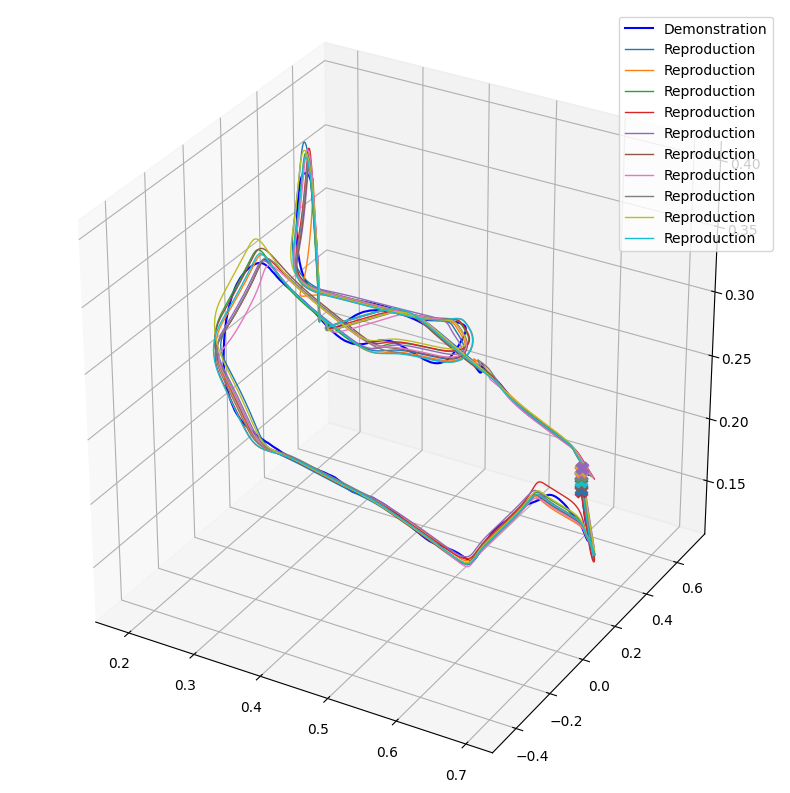

In [ ]:
#! /usr/bin/env python
##################################################
# Author: Noemie Jaquier, 2019
# License: MIT
# Contact: noemie.jaquier@idiap.ch
##################################################

import numpy as np
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import os.path
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat # loading data from matlab
from utils.gmr import Gmr
from utils.gmr import plot_gmm
from utils.gp_coregionalize_with_mean_regression import GPCoregionalizedWithMeanRegression
from utils.gmr_mean_mapping import GmrMeanMapping
from utils.gmr_kernels import Gmr_based_kernel
import argparse
import time
from fastdtw import fastdtw
import warnings
warnings.filterwarnings("ignore")

# GMR-based GPR on 3D trajectories with time as input
# parser = argparse.ArgumentParser()
# parser.add_argument('--data_name', default='Spiral', type=str)
# parser.add_argument('--n_gaussian', default=10, type=int)
# parser.add_argument('--n_test_execution', default=5, type=int)
# args = parser.parse_args()
# data_name = args.data_name

data_name = 'Towel'
n_gaussian = 20
n_test_execution = 10

demos = np.load('3D_robot_periodic/'+data_name+'.npy')[:,:,:3]
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.set_aspect('equal')
# ax.plot(demos[0][:,0], demos[0][:,1], demos[0][:,2], color='blue')
# plt.show()

# Parameters
nb_data = demos[0].shape[0]
nb_data_sup = 0
nb_samples = 1
dt = 0.0033
input_dim = 1
output_dim = 3
in_idx = [0]
out_idx = [1, 2, 3]
nb_states = n_gaussian

nb_prior_samples = n_test_execution
nb_posterior_samples = 1

# Create time data
demos_t = [np.arange(demos[i].shape[0])[:, None] + 1 for i in range(nb_samples)]
# Stack time and position data
demos_tx = [np.hstack([demos_t[i]*dt, demos[i]]) for i in range(nb_samples)]

# Stack demos
demos_np = demos_tx[0]
for i in range(1, nb_samples):
    demos_np = np.vstack([demos_np, demos_tx[i]])

X = demos_np[:, 0][:, None]
Y = demos_np[:, 1:]

# Train data for GPR
X_list = [np.hstack((X, X)) for i in range(output_dim)]
Y_list = [Y[:, i][:, None] for i in range(output_dim)]

# Test data
Xt = dt * np.arange(demos[0].shape[0] + nb_data_sup)[:, None]
nb_data_test = Xt.shape[0]
Xtest, _, output_index = GPy.util.multioutput.build_XY([np.hstack((Xt, Xt)) for i in range(output_dim)])


begin_train = time.time()
# GMM
gmr_model = Gmr(nb_states=nb_states, nb_dim=input_dim + output_dim, in_idx=in_idx, out_idx=out_idx)
gmr_model.init_params_kbins(demos_np.T, nb_samples=nb_samples)
gmr_model.gmm_em(demos_np.T)

# GMR prediction
mu_gmr = []
sigma_gmr = []
for i in range(Xt.shape[0]):
    mu_gmr_tmp, sigma_gmr_tmp, H_tmp = gmr_model.gmr_predict(Xt[i])
    mu_gmr.append(mu_gmr_tmp)
    sigma_gmr.append(sigma_gmr_tmp)

mu_gmr = np.array(mu_gmr)
sigma_gmr = np.array(sigma_gmr)

# Define GPR likelihood and kernels
likelihoods_list = [GPy.likelihoods.Gaussian(name="Gaussian_noise_%s" %j, variance=0.01) for j in range(output_dim)]
# kernel_list = [GPy.kern.RBF(1, variance=1., lengthscale=0.1) for i in range(gmr_model.nb_states)]
kernel_list = [GPy.kern.Matern52(1, variance=1., lengthscale=5.) for i in range(gmr_model.nb_states)]

# Fix variance of kernels
for kernel in kernel_list:
    kernel.variance.fix(1.)
    kernel.lengthscale.constrain_bounded(0.01, 10.)

# Bound noise parameters
for likelihood in likelihoods_list:
    likelihood.variance.constrain_bounded(0.001, 0.05)

# GPR model
K = Gmr_based_kernel(gmr_model=gmr_model, kernel_list=kernel_list)
mf = GmrMeanMapping(2*input_dim+1, 1, gmr_model)

m = GPCoregionalizedWithMeanRegression(X_list, Y_list, kernel=K, likelihoods_list=likelihoods_list, mean_function=mf)

# Parameters optimization
m.optimize('bfgs', max_iters=100, messages=True)

# Print model parameters
#print(m)
print(" ")
print("******* Data "+ data_name +" *******")
print(" ")
print("#######################################")
print("Training time",time.time() - begin_train)
print("#######################################")
# GPR prior (no observations)

begin_prior = time.time()
prior_traj = []
prior_mean = mf.f(Xtest)[:, 0]
prior_kernel = m.kern.K(Xtest)
prior_time = time.time() - begin_prior
total_sampling_time = 0.0
for i in range(nb_prior_samples):
    one_sample_begin = time.time()
    prior_traj_tmp = np.random.multivariate_normal(prior_mean, prior_kernel)
    prior_traj.append(np.reshape(prior_traj_tmp, (output_dim, -1)))
    total_sampling_time += time.time() - one_sample_begin
print("#######################################")
print("Testing time",total_sampling_time/nb_prior_samples + prior_time)
print("#######################################")
prior_kernel_tmp = np.zeros((nb_data_test, nb_data_test, output_dim * output_dim))
for i in range(output_dim):
    for j in range(output_dim):
        prior_kernel_tmp[:, :, i * output_dim + j] = prior_kernel[i * nb_data_test:(i + 1) * nb_data_test, j * nb_data_test:(j + 1) * nb_data_test]
prior_kernel_rshp = np.zeros((nb_data_test, output_dim, output_dim))
for i in range(nb_data_test):
    prior_kernel_rshp[i] = np.reshape(prior_kernel_tmp[i, i, :], (output_dim, output_dim))




# Priors
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.set_aspect('equal')
# plt.plot(mu_gmr[:, 0], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3.)
# plt.scatter(mu_gmr[0, 0], mu_gmr[0, 1], color=[0.20, 0.54, 0.93], marker='X', s=80)
# plot_gmm(mu_gmr, prior_kernel_rshp, alpha=0.05, color=[0.64, 0.27, 0.73])
ax.plot(demos[0][:,0], demos[0][:,1], demos[0][:,2], color='blue', label='Demonstration')
total_dtw = 0.0
for i in range(nb_prior_samples):
    ax.plot(prior_traj[i][0], prior_traj[i][1], prior_traj[i][2], linewidth=1., label='Reproduction')
    ax.scatter3D(prior_traj[i][0, 0], prior_traj[i][1, 0], prior_traj[i][2,0], marker='X', s=80)
    # np.save('results/'+letter+'/'+letter+str(args.n_gaussian)+'.npy', prior_traj[i])
    # np.save('results/'+letter+'/demo.npy', demos[0])
    distance, path = fastdtw(demos[0, :, :3], prior_traj[i].T)
    total_dtw += distance
print("#######################################")
print("DTW",total_dtw / nb_prior_samples)
print("#######################################")
# plt.xlabel('$y_1$', fontsize=30)
# plt.ylabel('$y_2$', fontsize=30)
# plt.locator_params(nbins=3)
# plt.tick_params(labelsize=20)
# plt.tight_layout()
# plt.savefig('results/'+letter+'/GMRbGP_gmm_'+str(args.n_gaussian)+'priors_datasup.png')
ax.legend()
plt.show()

# save predicted trajectory

In [ ]:
with open('Towel_GMR_GP_pred.npy', 'wb') as f:
  np.save(f, prior_traj)